Student Performance Data set  
https://archive.ics.uci.edu/ml/datasets/Student+Performance 

# Predicting whether a student is in a romantic relationship
By Sébastien Rhéaume, Ryan Shar, Justin Wong, Robert Yip

## Introduction:

Aside from school, romance is often a big part of a student's life for some high school students. In our study, we look at three factors to assess whether we can predict if a student is in a relationship. Our data set consists of 395 secondary students from two Portuguese schools, with data on their backgrounds, math grades, and whether they are in a romantic relationship. The data is collected through questionnaires. We chose numeric factors such as age, number of absences, and their math grades to predict their relationship status.


In [26]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

## Preliminary Exploratory Data Analysis
Demonstrate that the dataset can be read from the web into R 


In [60]:
# dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"

# read into table
temp <- tempfile()
download.file(url,temp)
raw_data <- read_csv2(unz(temp, "student-mat.csv"))
print.data.frame(head(raw_data))     # print.data.frame is needed because the table is wide and has collapsed columns

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



  school sex age address famsize Pstatus Medu Fedu     Mjob     Fjob     reason
1     GP   F  18       U     GT3       A    4    4  at_home  teacher     course
2     GP   F  17       U     GT3       T    1    1  at_home    other     course
3     GP   F  15       U     LE3       T    1    1  at_home    other      other
4     GP   F  15       U     GT3       T    4    2   health services       home
5     GP   F  16       U     GT3       T    3    3    other    other       home
6     GP   M  16       U     LE3       T    4    3 services    other reputation
  guardian traveltime studytime failures schoolsup famsup paid activities
1   mother          2         2        0       yes     no   no         no
2   father          1         2        0        no    yes   no         no
3   mother          1         2        3       yes     no  yes         no
4   mother          1         3        0        no    yes  yes        yes
5   father          1         2        0        no    yes  yes        

### Wrangling table columns into factors
For our study, we will look at 6 factors to predict if the student is in a romantic relationship.

1. romantic
2. age
3. absences
4. G1
5. G2
6. G3

To simplify our research, we combine all 3 grades by summing them to get an overall grade, as we are not interested in a particular grade from one period.

In [61]:
#select columns and combine grades
data <- raw_data %>%
    select (romantic, age, absences, G1, G2, G3) %>%
    mutate (overall_grade = G1 + G2 + G3) %>%
    select (-G1, -G2, -G3) %>%
    mutate(romantic = as_factor(romantic))

data

romantic,age,absences,overall_grade
<fct>,<dbl>,<dbl>,<dbl>
no,18,6,17
no,17,4,16
no,15,10,25
⋮,⋮,⋮,⋮
no,21,3,25
no,18,0,33
no,19,5,26


We also check for n/a, and we find that no data is missing.

In [29]:
sum(is.na(data))

[1] 0

### Summary of training data
Our data set has 395 observations, we apply a 75-25 split for training and testing. We consider the data is fairly split as we are only looking at 3 predictor variables.


In [52]:
set.seed(1)

#Splitting training data
data_split <- initial_split(data, prop = 0.75, strata = romantic)  
data_train <- training(data_split)   
data_test <- testing(data_split)
#data_train

#Summary
data_train %>% summarise(number_of_rows = nrow(data_train),
      mean_age = mean(age),
      mean_absences = mean(absences),
      mean_grade = mean(overall_grade),
      number_of_na = sum(is.na(data_train)))

romantic,age,absences,overall_grade
<fct>,<dbl>,<dbl>,<dbl>
no,18,6,17
no,17,4,16
no,15,10,25
⋮,⋮,⋮,⋮
no,21,3,25
no,18,0,33
no,19,5,26


number_of_rows,mean_age,mean_absences,mean_grade,number_of_na
<int>,<dbl>,<dbl>,<dbl>,<int>
297,16.67003,5.646465,31.94276,0


### Visualization of training data.


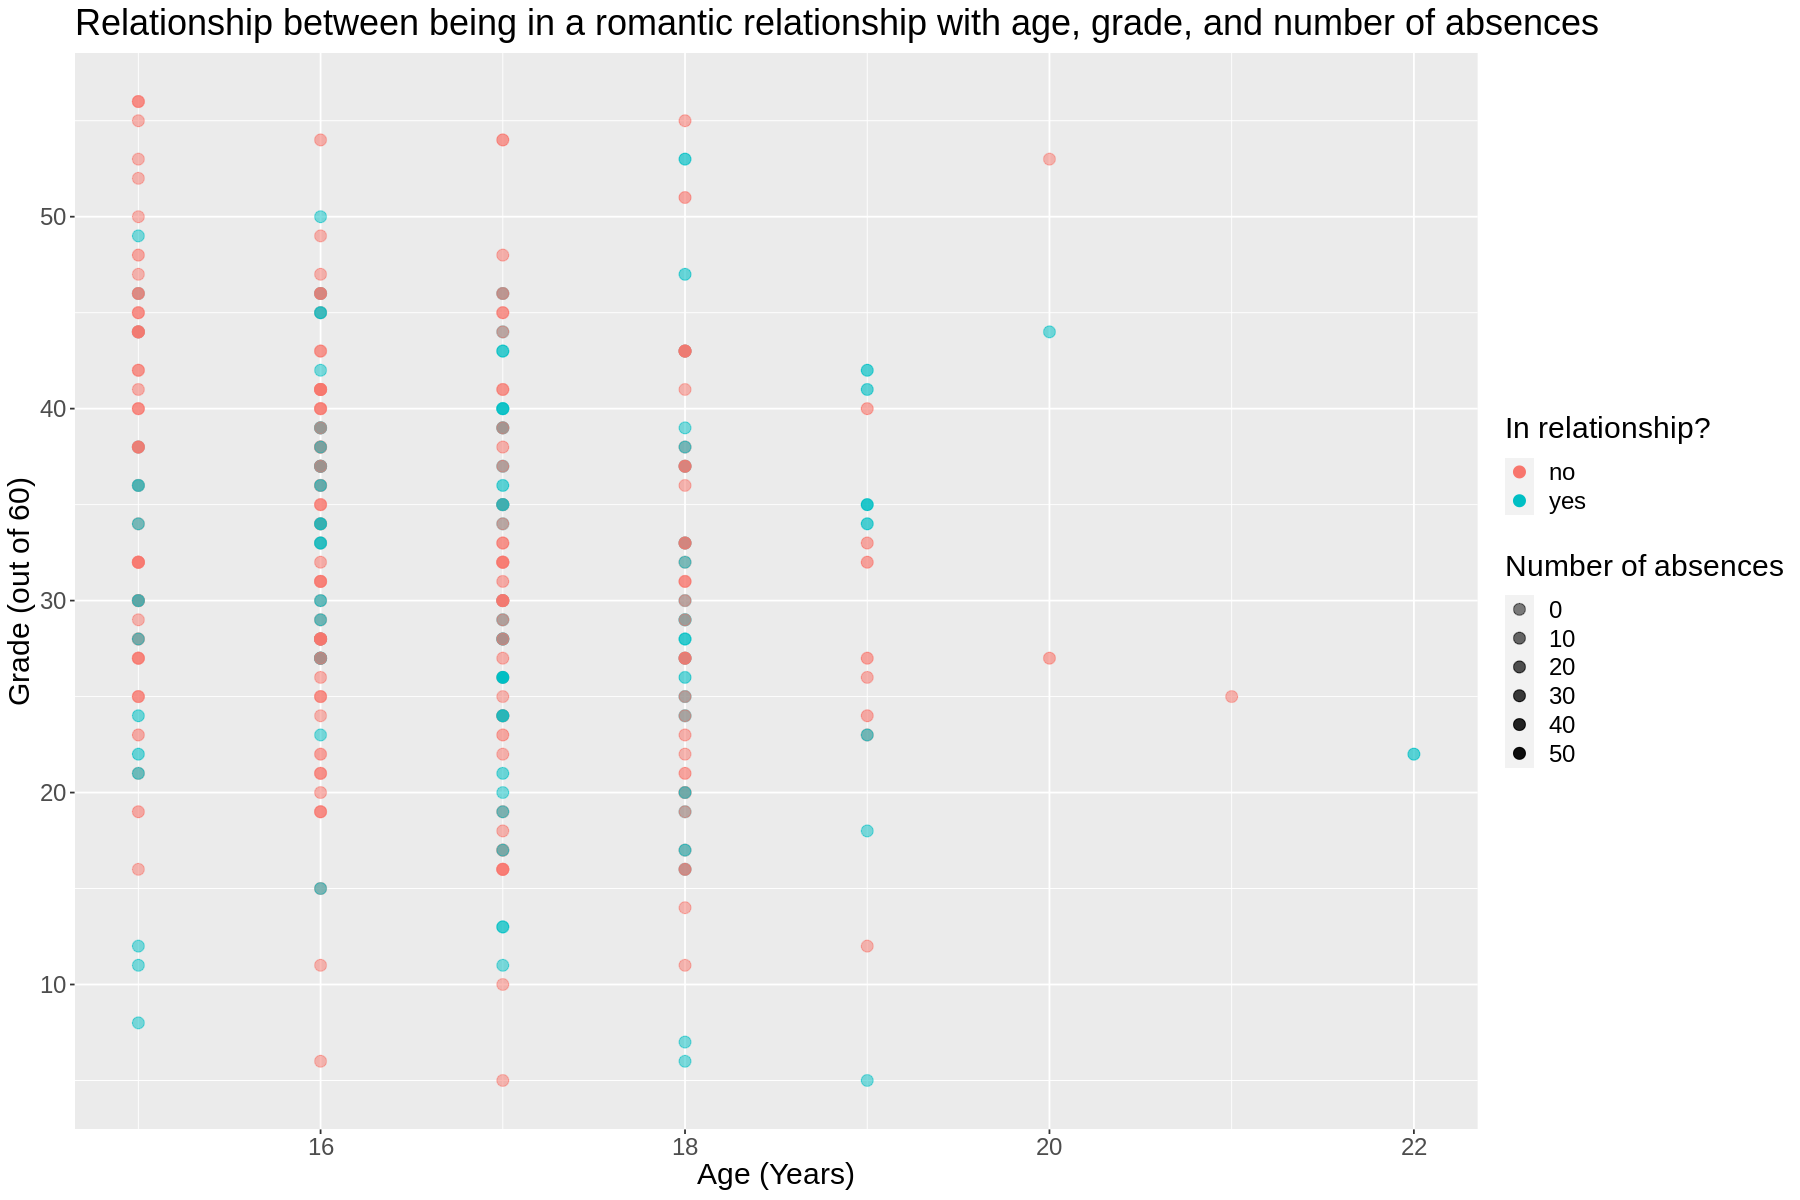

In [111]:
options(repr.plot.width = 15, repr.plot.height = 10) 
data_plot <- data_train %>%
    ggplot(aes(x=age, y=overall_grade, colour=romantic)) +
    geom_point(size = 3, aes(alpha=absences)) +
    ggtitle("Relationship between being in a romantic relationship with age, grade, and number of absences") +
    labs(x="Age (Years)", y="Grade (out of 60)", colour="In relationship?", alpha="Number of absences") +
    scale_alpha(range=c(0.5, 1)) +
    theme(text = element_text(size=18))
data_plot

## Methods

For our study, we will predict whether a student is in a relationship based on 3 numeric factors.

**romantic (categorical)** - our classification target. The outcome is binary: either yes or no to indicate the student's relationship status.  
**age (numeric)** - represents a student's age  
**absences (numeric)** - represents the count of absences in the term  
**overall_grade (numeric)** - represents the students grades over 3 periods, out of a maximum of 60. We created the overall_grade factor by summing G1, G2, and G3 as we are more interested in a student's overall grades than a single grade from a particular period.

We chose these factors because they are numeric from our data set, and we consider them to be relevant in predicting a student's relationship status.

#### Visualization
For visualization, we plan to create 3 scatterplots to show the relationship between each predictor variable and the prediction (romantic).  
We will also use a line plot to compare the accuracy of the prediction with the number of k neighbours.

### Expected Outcomes Significance

#### What do you expect to find?
We expect our chosen factors to be strong indicators of a student's relationship. We predict:
- Younger students are less likely to be in a relationship, because they are likely not ready
- Students with higher absences are more likely to be in a relationship, because they are skipping class to date
- Students with higher grades are less likely to be in a relationship, as their focus is on education

#### What impact could such findings have?
The study can provide information on how the chosen factors relate to a student being in a relationship. For example, if the study shows older students are more likely to be in a relationship, it can provide hope to younger students that they can find a partner when they become older, and their odds are just currently lower. It may provide a warning that grades may be lower if they are in a romantic relationship, if the study confirms such relationship between the factors.

#### What future questions could this lead to?
The study can be further expanded by including more factors or applied to a different population such as university students. The data can help guidance counselors guide students better or as gossip material for teen magazines.
